# Recognizing digits and numbers in natural scene images
## Part 1: SVHN dataset download and preprocessing

In [3]:
# These are all the modules we'll be using later. 
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
import tarfile
import h5py
from IPython.display import display, Image
from scipy import misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from PIL import Image as im
import seaborn as sns

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### Download the dataset to local machine. 
SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. SVHN is obtained from house numbers in Google Street View images. 

Original images with character level bounding boxes.

10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data

Full Numbers: train.tar.gz, test.tar.gz

http://ufldl.stanford.edu/housenumbers/train.tar.gz

http://ufldl.stanford.edu/housenumbers/test.tar.gz

<img src="images/examples_new.png"  width="50%" height="50%">

These are the original, variable-resolution, color house-number images with character level bounding boxes, as shown in the examples images above. (The blue bounding boxes here are just for illustration purposes. The bounding box information are stored in digitStruct.mat instead of drawn directly on the images in the dataset.) Each tar.gz file contains the orignal images in png format, together with a digitStruct.mat file, which can be loaded using Matlab. The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image. 


In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download: %s, expected size in bytes: %d' % (filename, expected_bytes))
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)

Found and verified train.tar.gz
Found and verified test.tar.gz


### Extract the dataset from the compressed .tar.gz file. 

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  print(root)
  return root
  
train_folder = maybe_extract(train_filename)
test_folder = maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
train
test already present - Skipping extraction of test.tar.gz.
test


#### Let's take a look at some of the data to make sure it looks sensible.  

In [4]:
def image_show(folder):
    """
    This function shows three .png images from a folder.
    Input is a folder name in string format.
    """
    title = ('Three images form %s folder:' % folder)
    fig = plt.figure(figsize=(18,5))
    counter = 1
    for image_tmp in random.sample(os.listdir(folder), 10):
        if image_tmp.endswith('.png'):
            fig.add_subplot(1, 3, counter)
            plt.imshow(plt.imread(folder+"/"+image_tmp))
            plt.title(folder+"/"+image_tmp)
        if counter == 3:
            break   
        counter += 1

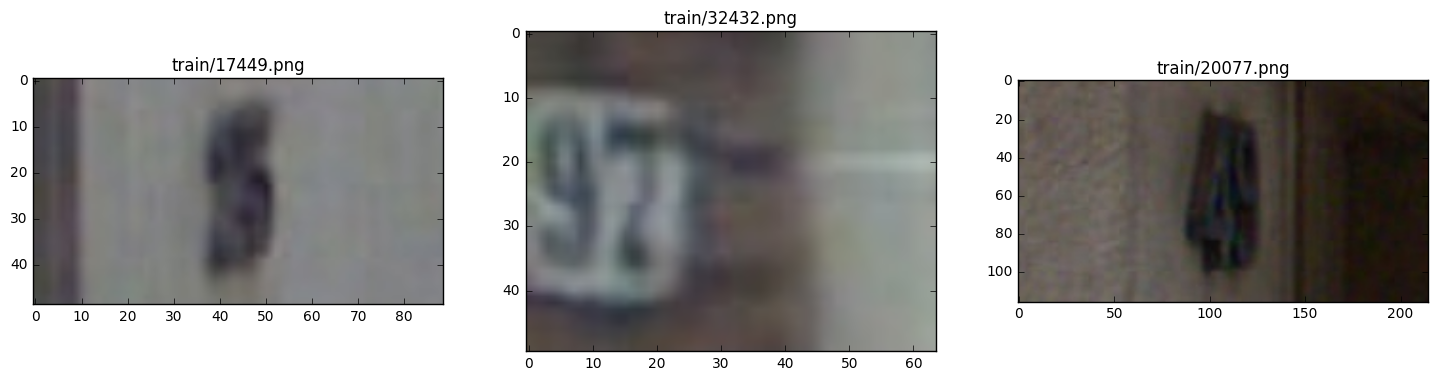

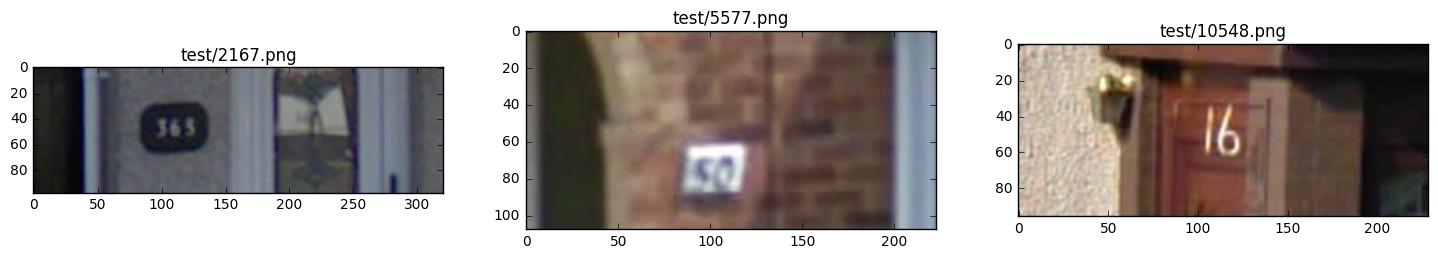

In [5]:
image_show(train_folder)
image_show(test_folder)

In [6]:
train_len = len([1 for file_tmp in os.listdir(train_folder) if file_tmp.endswith('.png')])
print("There are total %d train files" % train_len)
test_len = len([1 for file_tmp in os.listdir(test_folder) if file_tmp.endswith('.png')])
print("There are total %d test files" % test_len)

There are total 33402 train files
There are total 13068 test files


### Now we need to read information from difitStruct.mat files, thus we can label the images.

In [7]:
train_struct = h5py.File(train_folder+"/"+"digitStruct.mat", "r")
train_struct.keys()

[u'#refs#', u'digitStruct']

In [8]:
train_struct["digitStruct"].keys()

[u'bbox', u'name']

In [9]:
train_struct["digitStruct"].items()

[(u'bbox', <HDF5 dataset "bbox": shape (33402, 1), type "|O">),
 (u'name', <HDF5 dataset "name": shape (33402, 1), type "|O">)]

In [10]:
test_struct = h5py.File(test_folder+"/"+"digitStruct.mat")

In [11]:
test_struct["digitStruct"].items()

[(u'bbox', <HDF5 dataset "bbox": shape (13068, 1), type "|O">),
 (u'name', <HDF5 dataset "name": shape (13068, 1), type "|O">)]

In [12]:
train_bbox = train_struct["digitStruct"]["bbox"]
train_name = train_struct["digitStruct"]["name"]
test_bbox = test_struct["digitStruct"]["bbox"]
test_name = test_struct["digitStruct"]["name"]

In [13]:
def readName(dsFile, nameRef):
    """
    This function reads a string from the file using its reference and return file name as a string
    """
    nameObj = dsFile[nameRef]
    name = ''.join(chr(i) for i in nameObj)
    return name

In [14]:
def readBBox(dsFile, bboxRef):
    """
    This function reads a labels and BBox limits from the file using its references and returns integer values for 
    label (digit), height, left, top, width for each digit on an image
    """
    bboxGroup = dsFile[bboxRef]
    bboxKeys = bboxGroup.keys()
    len_tmp =  len(bboxGroup[bboxKeys[0]].value)
    bbox_dic = {}
    for lab_tmp in bboxKeys:
        if len_tmp > 1:
            bbox_dic[lab_tmp] = [int(dsFile[Ref_tmp[0]].value[0][0]) for Ref_tmp in bboxGroup[lab_tmp].value]
        else:
            bbox_dic[lab_tmp] = [int(bboxGroup[lab_tmp].value[0][0])]
    return bbox_dic

In [15]:
def mat_to_list(struct, t_name, t_bbox):
    """
    This functon reads structs and return a list of dictionaries containing information 
    about files (file name, labels, and bbox parameters,)
    """
    dsList = []
    for image_number in range(t_name.size):
        file_name_tmp = readName(struct, t_name[image_number].item())
        bbox_tmp = readBBox(struct, t_bbox[image_number].item())
        bbox_tmp['file_name'] = file_name_tmp
        #print(file_name_tmp)
        dsList.append(bbox_tmp)
    return dsList   

Collect train dataset information

In [16]:
train_ds_info = mat_to_list(train_struct, train_name, train_bbox)

Check train dataset labels and bbox information

In [17]:
train_ds_info[:3]

[{'file_name': '1.png',
  u'height': [219, 219],
  u'label': [1, 9],
  u'left': [246, 323],
  u'top': [77, 81],
  u'width': [81, 96]},
 {'file_name': '2.png',
  u'height': [32, 32],
  u'label': [2, 3],
  u'left': [77, 98],
  u'top': [29, 25],
  u'width': [23, 26]},
 {'file_name': '3.png',
  u'height': [15, 15],
  u'label': [2, 5],
  u'left': [17, 25],
  u'top': [5, 5],
  u'width': [8, 9]}]

Collect test dataset information

In [18]:
test_ds_info = mat_to_list(test_struct, test_name, test_bbox)

Check test dataset labels and box information

In [19]:
test_ds_info[:3]

[{'file_name': '1.png',
  u'height': [30],
  u'label': [5],
  u'left': [43],
  u'top': [7],
  u'width': [19]},
 {'file_name': '2.png',
  u'height': [23, 23, 23],
  u'label': [2, 1, 10],
  u'left': [99, 114, 121],
  u'top': [5, 8, 6],
  u'width': [14, 8, 12]},
 {'file_name': '3.png',
  u'height': [16],
  u'label': [6],
  u'left': [61],
  u'top': [6],
  u'width': [11]}]

Close both HDF5 files

In [20]:
train_struct.close()
test_struct.close()

In [21]:
def maybe_pickle(train_ds_info, test_ds_info, force=False, name="datasets_info"):
    """
    This function will try to pikle a dict(train_ds_info and test_ds_info) into file 
    named datasets_info.pickle if it is not existed. 
    """
    set_filename = name+'.pickle'
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      ds_info_combined = {"train_ds_info": train_ds_info, "test_ds_info": test_ds_info,}
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(ds_info_combined, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
    return "Done"

Pikling extracted information form difitStruct.mat files for training and testing datasets.

In [22]:
maybe_pickle(train_ds_info, test_ds_info)

datasets_info.pickle already present - Skipping pickling.


'Done'

### Load train and test data sets information from datasets_info.pickle
You may re-start it from here in case of kernel crashed. The first cell need to be re-run too.

In [4]:
train_folder = 'train'
test_folder = 'test'

In [5]:
pickle_file = "datasets_info.pickle"
try:
    with open(pickle_file, 'rb') as f:
        ds_info = pickle.load(f)
        train_ds_info_l = ds_info["train_ds_info"]
        test_ds_info_l = ds_info["test_ds_info"]
        f.close()
except Exception as e:
    print('Unable to process data from', pickle_file, ':', e)
    raise

In [6]:
def test_ds_info(tmp_ds_info, n=3):
    """
    Check datasets info helper. 
    Input is a list of dictionaries containing each image information
    and n - how many records needed to be checked (default n=3)
    """
    print("Review records in the dataset info")
    for record_tmp in range(n):
        print(tmp_ds_info[record_tmp])

In [7]:
test_ds_info(train_ds_info_l, 4)

Review records in the dataset info
{'file_name': '1.png', u'top': [77, 81], u'height': [219, 219], u'width': [81, 96], u'label': [1, 9], u'left': [246, 323]}
{'file_name': '2.png', u'top': [29, 25], u'height': [32, 32], u'width': [23, 26], u'label': [2, 3], u'left': [77, 98]}
{'file_name': '3.png', u'top': [5, 5], u'height': [15, 15], u'width': [8, 9], u'label': [2, 5], u'left': [17, 25]}
{'file_name': '4.png', u'top': [13, 13], u'height': [34, 34], u'width': [15, 13], u'label': [9, 3], u'left': [57, 72]}


In [8]:
test_ds_info(test_ds_info_l, 4)

Review records in the dataset info
{'file_name': '1.png', u'top': [7], u'height': [30], u'width': [19], u'label': [5], u'left': [43]}
{'file_name': '2.png', u'top': [5, 8, 6], u'height': [23, 23, 23], u'width': [14, 8, 12], u'label': [2, 1, 10], u'left': [99, 114, 121]}
{'file_name': '3.png', u'top': [6], u'height': [16], u'width': [11], u'label': [6], u'left': [61]}
{'file_name': '4.png', u'top': [6], u'height': [17], u'width': [14], u'label': [1], u'left': [32]}


### Train, test, and validation Datasets and labels prep

Convert the dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

In [9]:
def LTHW_finder(t_ds_info_l, max_digits=1000, verb=True):
    """
    This function count how many digits in each image and consolidate this information into a dictionary.
    Calculating bounding box can be limited to a certain number of digits in the number on image. 
    """
    LTHW_dic = {"left": 1000, "top": 1000, "height": 0, "width": 0}
    digits_dic = {}
    for im_idx in range(len(t_ds_info_l)):
        info_tmp = t_ds_info_l[im_idx]
        digits_tmp = len(info_tmp["label"])
        if digits_tmp <= max_digits:
            # get digits info
            if digits_tmp in digits_dic.keys():
                digits_dic[digits_tmp] += 1
            else:
                digits_dic[digits_tmp] = 1
    if verb:
        print("Total images in dataset:", im_idx+1)
    return {"digits": digits_dic}

In [10]:
train_ds_info_l_summary = LTHW_finder(train_ds_info_l)
print(train_ds_info_l_summary)

Total images in dataset: 33402
{'digits': {1: 5137, 2: 18130, 3: 8691, 4: 1434, 5: 9, 6: 1}}


In [11]:
test_ds_info_l_summary = LTHW_finder(test_ds_info_l)
print(test_ds_info_l_summary)

Total images in dataset: 13068
{'digits': {1: 2483, 2: 8356, 3: 2081, 4: 146, 5: 2}}


In [12]:
def plot_digits(ds_tmp, title_tmp):
    plt.bar(ds_tmp['digits'].keys(), ds_tmp['digits'].values(), align='center')
    plt.yscale('log')
    plt.xlim(0.5, max(ds_tmp['digits'].keys())+0.5)
    plt.title('Digits in the %s dataset' % title_tmp)
    plt.xlabel("Digits in the number")
    plt.ylabel("Total number of images")

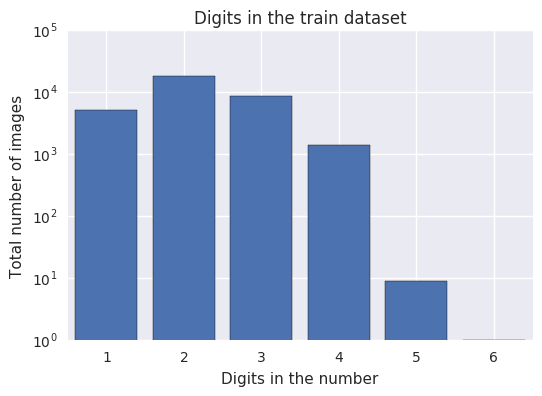

In [13]:
plot_digits(train_ds_info_l_summary, 'train')

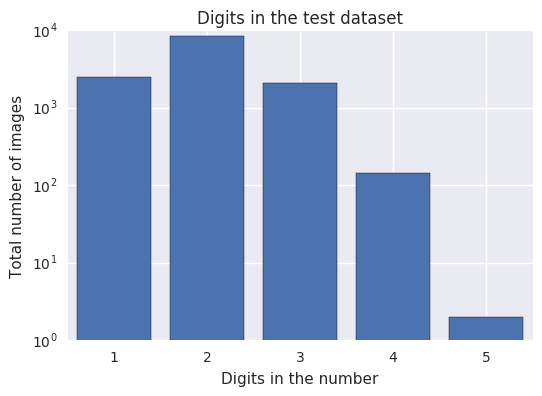

In [14]:
plot_digits(test_ds_info_l_summary, 'test')

### There are total 33402 images in train dataset. 
There are 9 images with 5-digits number and one is a 6-digits number. We will exclude those images in the future model building because they are not representative to the entire dataset and could be treated as outliers. 

### There are total 13068 images in test dataset.
Similarly, we will exclude 5-digits images from test dataset (there are two of them).

We need to recalculate the *global* bounding box for images excluding 5- and 6-digits images.

In [15]:
train_ds_info_l_summary = LTHW_finder(train_ds_info_l, 4)
print(train_ds_info_l_summary)

Total images in dataset: 33402
{'digits': {1: 5137, 2: 18130, 3: 8691, 4: 1434}}


In [16]:
test_ds_info_l_summary = LTHW_finder(test_ds_info_l)
print(test_ds_info_l_summary)

Total images in dataset: 13068
{'digits': {1: 2483, 2: 8356, 3: 2081, 4: 146, 5: 2}}


#### Explore and visualize images height and width

In [17]:
def progress_report(count, totalSize):
  """A reporter to show the progress of processing. Reports every 1% change in progress.
  """
  global last_percent_reported
  percent = int(count * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 10 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

In [18]:
def images_height_width(tmp_ds_l, tmp_folder):
    """
    input: 
    tmp_ds_l: dataset info lists such as train_ds_info_l or test_ds_info_l
    tmp_folder: location of datasets (path to images)
    Return two lists: height of the images and width of the images
    """
    tmp_height = []
    tmp_width = []
    counter = 0
    total_images = len(tmp_ds_l)
    print('Processing raw images ')
    for image in tmp_ds_l:
        image_file_tmp = os.path.join(tmp_folder, image["file_name"]) # read image path
        image_data = im.open(image_file_tmp)
        tmp_width.append(image_data.size[0])
        tmp_height.append(image_data.size[1])
        counter += 1
        # report progress
        progress_report(counter, total_images)
    print('\nProcessing Completed!')
    return tmp_height, tmp_width

In [19]:
last_percent_reported = None
train_height_l, train_width_l = images_height_width(train_ds_info_l, train_folder)

Processing raw images 
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100%
Processing Completed!


In [20]:
last_percent_reported = None
test_height_l, test_width_l = images_height_width(test_ds_info_l, test_folder)

Processing raw images 
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100%
Processing Completed!


In [26]:
print("Train dataset statistics:")
print("height max %d, min %d, mean %.2f, median %.2f, std %.2f" % (np.max(train_height_l), 
                            np.min(train_height_l), np.mean(train_height_l), np.median(train_height_l), np.std(train_height_l)))
print("width max %d, min %d, mean %.2f, median %.2f, std %.2f" % (np.max(train_width_l), 
                            np.min(train_width_l), np.mean(train_width_l), np.median(train_width_l), np.std(train_width_l)))
print("Test dataset statistics:")
print("height max %d, min %d, mean %.2f, median %.2f, std %.2f" % (np.max(test_height_l), np.min(test_height_l), 
                            np.mean(test_height_l), np.median(test_height_l), np.std(test_height_l)))
print("width max %d, min %d, mean %.2f, median %.2f, std %.2f" % (np.max(test_height_l), np.min(test_height_l), 
                            np.mean(test_width_l), np.median(test_width_l), np.std(test_width_l)))

Train dataset statistics:
height max 501, min 12, mean 57.21, median 47.00, std 36.18
width max 876, min 25, mean 128.28, median 104.00, std 80.55
Test dataset statistics:
height max 516, min 13, mean 71.57, median 53.00, std 52.75
width max 516, min 13, mean 172.58, median 132.00, std 122.58


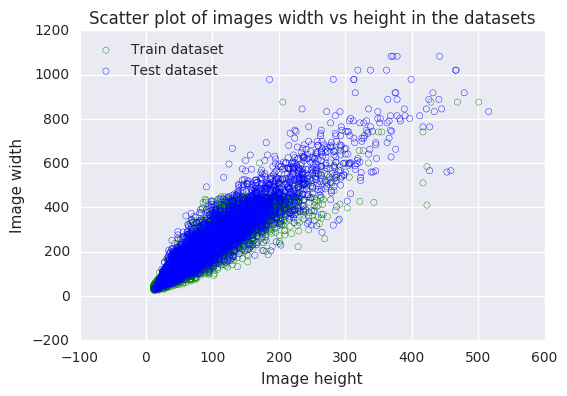

In [24]:
plt.scatter(train_height_l, train_width_l, facecolors='none', edgecolors='g', marker='o', label="Train dataset")
plt.scatter(test_height_l, test_width_l, facecolors='none', edgecolors='b', marker='o', label="Test dataset")
plt.title('Scatter plot of images width vs height in the datasets')
plt.xlabel('Image height')
plt.ylabel('Image width')
plt.legend(loc=2)

In [25]:
sns.set_style({'axes.grid' : False})

* The images will be cropped base on bounding boxes size and resized to 32x32
* The images with more that 4 digits will be excluded from datasets
* images will be converted to grayscale and normalized
* Colorimetric (luminance-preserving) conversion to grayscale: R * 299/1000 + G * 587/1000 + B * 114/1000 [Ref. http://pillow.readthedocs.io/en/3.4.x/reference/Image.html]
* image labels: [N, D1, D2, D3, D4], whereN is a number of digits in the image, Dn is a number from 0 to 10, 0 means that there is no digit at this position, and 10 means there is a 0 in this position. For example, 201 will be labeled as [3, 2, 10, 1, 0]
* The training and test dataset will be merged, randomized, and split into 70% traning, 15% validation, and 15% test datasets.

In [37]:
test_ds_info_l[1]

{'file_name': '2.png',
 u'height': [23, 23, 23],
 u'label': [2, 1, 10],
 u'left': [99, 114, 121],
 u'top': [5, 8, 6],
 u'width': [14, 8, 12]}

In [38]:
image_size = 32
delta = int(image_size * 0.1)
last_percent_reported = None

def ds_prep(tmp_ds, tmp_folder, max_digits=4):
    """
    This function will process raw images and return final dataset and labels for this dataset.
    Input: tmp_ds: dataset; tmp_folder: location of dataset; max_difits: maximim digits on image to include in final dataset. 
    """
    # get info on how many images with max_digits
    total_images = sum(LTHW_finder(tmp_ds, max_digits, verb=False)['digits'].values())
    # create an array to save images data
    final_dataset = np.ndarray(shape=(total_images, image_size, image_size), dtype='float32')
    # create a label dataset: image labels: [N, D1, D2, D3, D4], 
    # where N is a number of digits in the image
    # Dn is a number from 0 to 10, 0 means that there is no digit at this position, and 10 means there is a 0 in this position 
    final_labels = np.zeros(shape=(total_images, max_digits+1), dtype='int')
    # set image counter to 0
    counter = 0
    print('Processing raw images ') 
    for image_info in tmp_ds:
        image_file_tmp = os.path.join(tmp_folder, image_info["file_name"]) # read image path
        if len(image_info["label"]) <= max_digits:
            try:
                # read image
                image_data = im.open(image_file_tmp)
                # convert to grey scale
                image_data = image_data.convert('L')
                # crop image
                left = min(image_info["left"])
                top = min(image_info["top"])
                width = max(image_info["width"]) + max(image_info["left"]) #- left
                height = max(image_info["height"]) + max(image_info["top"]) #- top
                image_data_crop = image_data.crop((left-delta, top-delta, width+delta, height+delta))
                # resize image
                image_data_resize = image_data_crop.resize((image_size, image_size))
                image_mean = np.mean(image_data_resize, dtype='float32')
                image_std = np.std(image_data_resize, dtype='float32', ddof=1)
                image_data_final = (np.array(image_data_resize, dtype='float32') - image_mean) / image_std
                # save image into the images dataset
                final_dataset[counter, :, :] = image_data_final
                # fill out the labels dataset
                final_labels[counter, 0] = len(image_info["label"])
                final_labels[counter, 1:len(image_info["label"])+1] = [label_tmp for label_tmp in image_info["label"]]
                counter += 1
                # report progress
                progress_report(counter, total_images)
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    print('\nProcessing Completed!')
    return final_dataset, final_labels

In [39]:
train_dataset_new, train_labels_new = ds_prep(train_ds_info_l, train_folder)

Processing raw images 
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100%
Processing Completed!


In [40]:
test_dataset_new, test_labels_new = ds_prep(test_ds_info_l, test_folder)

Processing raw images 
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100%
Processing Completed!


In [41]:
def image_show_ds(t_ds_new, t_l_new, name):
    """
    This function shows three images with their labels from a folder.
    Input are image dataset and corresponding labels dataset.
    """
    print("%s image dataset shape" % name, t_ds_new.shape)
    print("%s labels dataset shape" % name, t_l_new.shape)
    title = ('Three randomly chosen images from the loaded dataset')
    fig = plt.figure(figsize=(18,5))
    counter = 1
    for image_idx_tmp in random.sample(range(t_l_new.shape[0]), 3):
        fig.add_subplot(1, 3, counter)
        plt.imshow(t_ds_new[image_idx_tmp,:,:])
        plt.title("Labels: %s" % t_l_new[image_idx_tmp])
        counter += 1

Train image dataset shape (33392, 32, 32)
Train labels dataset shape (33392, 5)
Test image dataset shape (13066, 32, 32)
Test labels dataset shape (13066, 5)


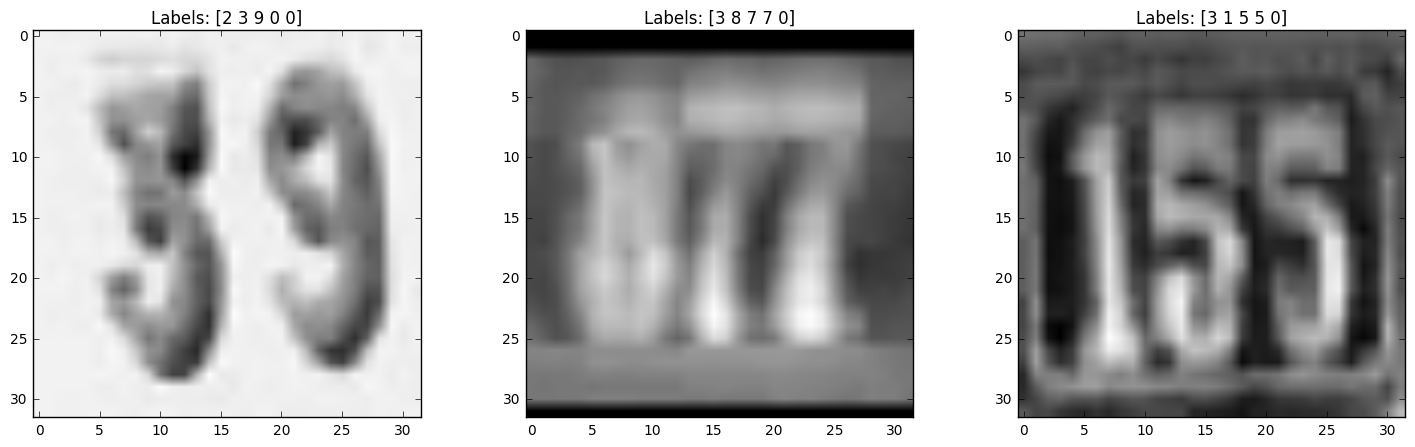

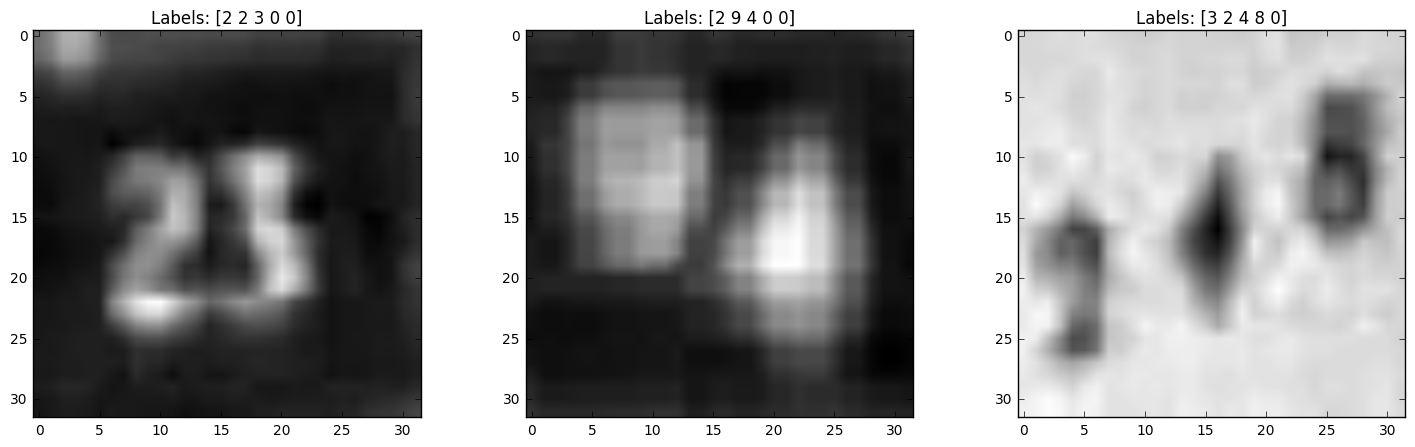

In [25]:
image_show_ds(train_dataset_new, train_labels_new, "Train")
image_show_ds(test_dataset_new, test_labels_new, "Test")

In [47]:
# merge datasets
dataset_merged = np.concatenate((train_dataset_new, test_dataset_new))
print(dataset_merged.shape)
labels_merged = np.concatenate((train_labels_new, test_labels_new))
print(labels_merged.shape)

(46458, 32, 32)
(46458, 5)


### Randomize dataset

In [48]:
def randomize(dataset, labels):
    """
    This function radomize input dataset and it's labels.
    """
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [49]:
dataset_random, labels_random = randomize(dataset_merged, labels_merged)

Merged and randomized image dataset shape (46458, 32, 32)
Merged and randomized labels dataset shape (46458, 5)


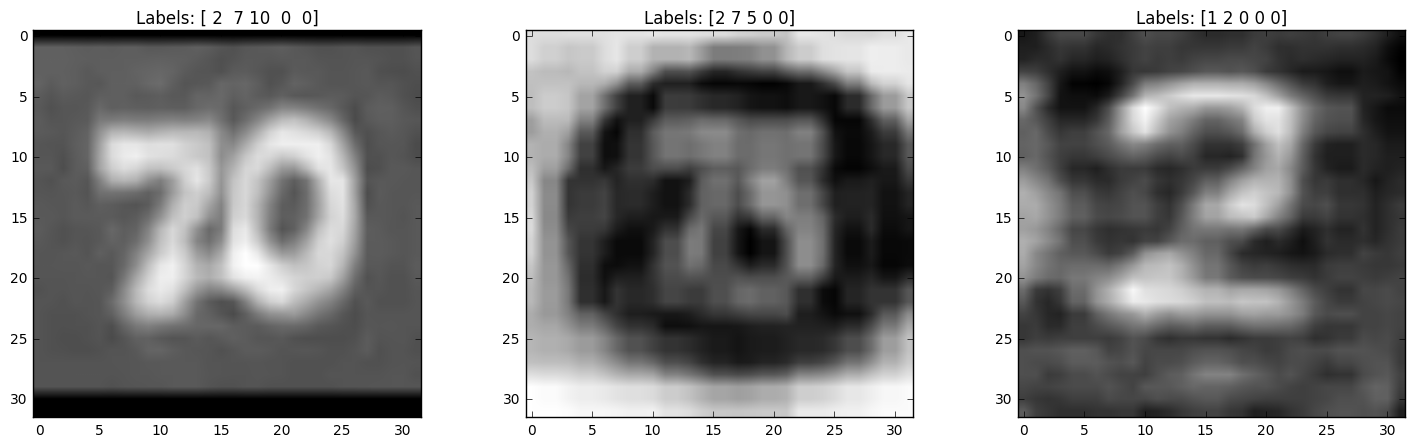

In [50]:
# quick chek of the dataset and labels
image_show_ds(dataset_random, labels_random, "Merged and randomized")

### Splitting dataset into training 70%, validation 15% and test 15% datasets

In [51]:
valid_size = int(dataset_random.shape[0] * 0.15)
valid_dataset_final = dataset_random[:valid_size,:,:]
valid_labels_final = labels_random[:valid_size]
test_dataset_final = dataset_random[valid_size:valid_size*2,:,:]
test_labels_final = labels_random[valid_size:valid_size*2]
train_dataset_final = dataset_random[valid_size*2:,:,:]
train_labels_final = labels_random[valid_size*2:]
                             
print(train_dataset_final.shape, train_labels_final.shape)
print(test_dataset_final.shape, test_labels_final.shape)
print(valid_dataset_final.shape, valid_labels_final.shape)

(32522, 32, 32) (32522, 5)
(6968, 32, 32) (6968, 5)
(6968, 32, 32) (6968, 5)


### Saving split data into train_SVHN.pickle, valid_SVHN.pickle, and test_SVHN.pickle files 

In [52]:
def maybe_pickle_final(ds_im, ds_l, name, force=False):
    """
    This function will try to pikle a dict(name_dataset, name_labels) into file 
    named name_SVHN.pickle if it is not existed. Can be foreced if force is True.
    """
    set_filename = name+'_SVHN.pickle'
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      ds_combined = {'images': ds_im, 'labels': ds_l,}
      try:
        with open(set_filename, 'wb') as f:
            pickle.dump(ds_combined, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
    return "Done"

In [53]:
maybe_pickle_final(valid_dataset_final, valid_labels_final, 'valid')

Pickling valid_SVHN.pickle.


'Done'

In [54]:
maybe_pickle_final(test_dataset_final, test_labels_final, 'test')

Pickling test_SVHN.pickle.


'Done'

In [55]:
maybe_pickle_final(train_dataset_final, train_labels_final, 'train')

Pickling train_SVHN.pickle.


'Done'